# DS340 Final Project - Using ML to generate music
Ben Gardiner

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
# import sklearn
!pip install pretty_midi
import pretty_midi
from tqdm import tqdm
import random 
import re
import collections 
import pathlib 
import glob 
warnings.simplefilter("ignore", UserWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Introduction

For this assignment I wanted to generate unique artifical music using machine learning. Music can be represented a sequence of sounds following each other, so I collected data in time series format and used a LSTM model to predict the sound that would come next.

# Methodology

1. get data 
2. preprocess data 
3. build modeel
4. train it 
5. generate new music

# Getting data 

The Maestro dataset is a collection of over 200 hours of classical piano performances in MIDI and audio formats, spanning a wide range of musical styles and composers. It includes annotations such as tempo, dynamics, and pedal usage, and is commonly used for machine learning, music information retrieval, and computer music research. It can be downloaded for non-commercial use from the Magenta project website.

https://magenta.tensorflow.org/datasets/maestro

In [19]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

midi_paths = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(midi_paths))

Number of files: 1282


In [20]:
sample_file = midi_paths[0]
sample_object = pretty_midi.PrettyMIDI(sample_file)

# Preprocessing our data

Right now our data is a bunch of MIDI files stored in our directory, but we need to transform these files into something the neural network can consume. We will preprocess the data with the following steps...

1. take a MIDI object and turn it into a sequence of notes 
2. visualize the song by plotting a sequence of notes 
3. iterate through all the songs in the dataset and collect song data (sequence of notes, name of song, length of second (seconds), etc.)

In [21]:

def midi_to_notes(midi_object):
  # source - https://www.tensorflow.org/tutorials/audio/music_generation
  instrument = midi_object.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start
  
  for note in sorted_notes:
    start = note.start
    end = note.end
    pitch = note.pitch
    notes['pitch'].append(pitch)
    notes['note_name'].append(pretty_midi.note_number_to_name(pitch)) # e.g 50 -> D3
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

midi_to_notes(sample_object)


,pitch,note_name,start,end,step,duration
0,73,C#5,1.009115,1.389323,0.000000,0.380208
1,64,E4,1.062500,1.488281,0.053385,0.425781
2,68,G#4,1.067708,1.447917,0.005208,0.380208
3,37,C#2,1.078125,4.541667,0.010417,3.463542
4,61,C#4,1.089844,1.635417,0.011719,0.545573
...,...,...,...,...,...,...
23830,80,G#5,2094.555990,2096.174479,0.424479,1.618490
23831,85,C#6,2094.555990,2096.311198,0.000000,1.755208
23832,89,F6,2094.555990,2096.398438,0.000000,1.842448
23833,77,F5,2094.557292,2096.207031,0.001302,1.649740


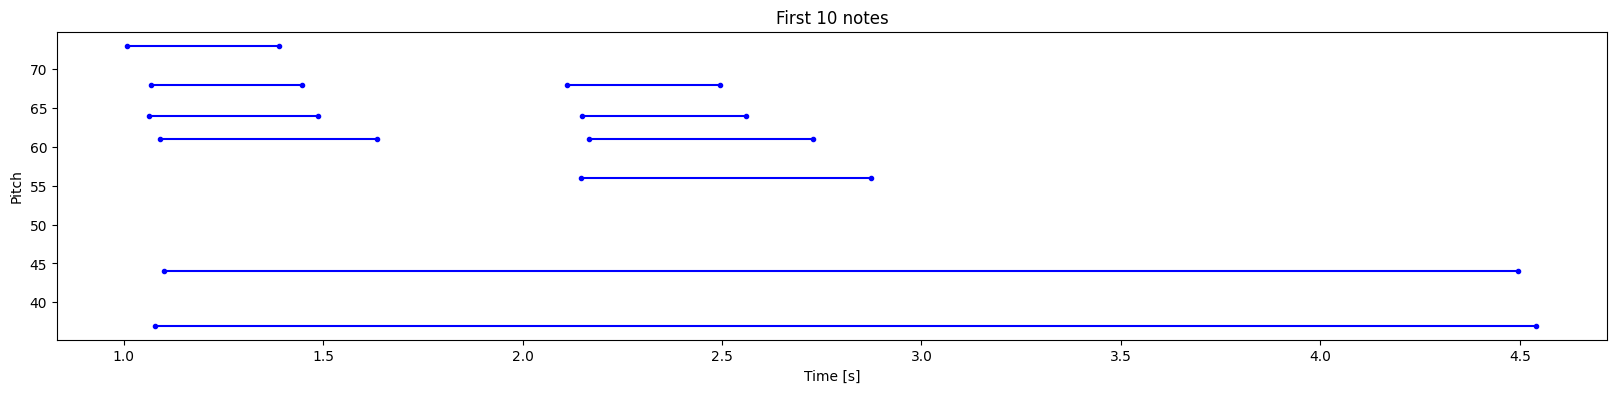

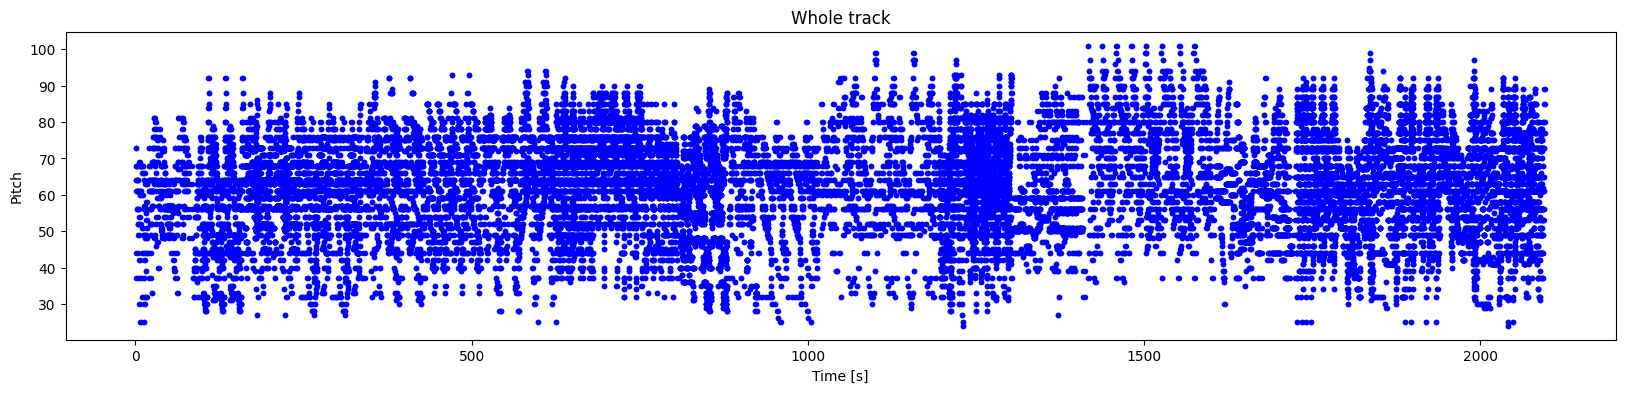

In [22]:
def plot_piano_roll(notes: pd.DataFrame, count: int = None):
  """Used to visualize the notes in a track."""
  # source - https://www.tensorflow.org/tutorials/audio/music_generation

  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

plot_piano_roll(midi_to_notes(sample_object),count=10)
plot_piano_roll(midi_to_notes(sample_object))

In [23]:
def get_song_data(file_path):
    """Returns song name, length, number of notes, and vectorized notes for an INDIVIDUAL song"""
    midi_object = pretty_midi.PrettyMIDI(file_path)

    # length of song in seconds
    song_length = midi_object.get_end_time()

    # name of song
    song_name = os.path.basename(file_path)

    # notes df 
    notes_df = midi_to_notes(midi_object)
    num_notes = len(notes_df)

    # sequences of notes in array form e.g [50, 51, 52, 53, 54]
    vectorized_notes = notes_df[['pitch','step','duration']].values

    return song_name, song_length, num_notes, vectorized_notes
    
get_song_data(sample_file)

('MIDI-Unprocessed_Recital20_MID--AUDIO_20_R1_2018_wav--4.midi',
 2098.052083333333,
 23835,
 array([[7.30000000e+01, 0.00000000e+00, 3.80208333e-01],
        [6.40000000e+01, 5.33854167e-02, 4.25781250e-01],
        [6.80000000e+01, 5.20833333e-03, 3.80208333e-01],
        ...,
        [8.90000000e+01, 0.00000000e+00, 1.84244792e+00],
        [7.70000000e+01, 1.30208333e-03, 1.64973958e+00],
        [7.30000000e+01, 6.51041667e-03, 4.16666667e-02]]))

In [24]:
def get_data(midi_paths):
    data = []
    for path in tqdm(midi_paths):
        try:
            song_name, song_length, num_notes, vectorized_notes = get_song_data(path)
            song_data = [song_name, song_length, num_notes, vectorized_notes]
            
            # we only want songs that are less than 5 minutes
            if song_length < 300: 
                data.append(song_data)
            else:
                continue
        except:
            print(f"Error with {path}")

    df = pd.DataFrame(data, columns=["song name", "song length (seconds)", "number of notes", "vectorized_notes"])
    # print(df.head())

    all_notes = df['vectorized_notes']

    return all_notes,df

all_notes, df = get_data(midi_paths)

df.head()

100%|██████████| 1282/1282 [07:15<00:00,  2.94it/s]


,song name,song length (seconds),number of notes,vectorized_notes
0,MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1...,249.329427,1094,"[[43.0, 0.0, 2.095052083333333], [50.0, 0.3880..."
1,MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_...,216.591146,1095,"[[77.0, 0.0, 1.1861979166666665], [81.0, 1.096..."
2,MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1...,295.718750,3821,"[[63.0, 0.0, 0.3346354166666667], [39.0, 0.666..."
3,MIDI-Unprocessed_Recital9-11_MID--AUDIO_09_R1_...,194.766927,3085,"[[50.0, 0.0, 0.1367187499999999], [55.0, 0.063..."
4,MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2...,256.501302,1122,"[[62.0, 0.0, 1.3606770833333335], [59.0, 0.016..."


### Creating input and output sequences

Right now our data is a list of songs where each song is a sequence of notes. However, we need to reshape our data into something the model can understand, so we need to create input and output sequences.

We iterate through all the data and collect 64 note sequences and the note that follows. We'll train the model on the 64 note sequences and hope it learns what note should follow. Just like you could use a time series model to predict where a stock might be based on where it was in the past.

In [25]:
from tensorflow.keras.utils import to_categorical

def create_input_output(data, sequence_length=25):
    input_seqs = []
    output_notes = []

    for song in data:
        for i in range(0, len(song) - sequence_length):
            input_seq = song[i:i+sequence_length]
            output_note = song[i+sequence_length]

            input_seqs.append(input_seq)
            output_notes.append(output_note)

    input_seqs = np.array(input_seqs)
    output_seqs = np.array([
        # to_categorical(np.array([note[0] for note in output_notes])), # pitch
        np.array([note[0] for note in output_notes]), # pitch
        np.array([note[1] for note in output_notes]), # step
        np.array([note[2] for note in output_notes]) # duration
    ]).transpose()

    return input_seqs, output_seqs

input_seqs, output_seqs = create_input_output(all_notes)

print("Input Sequences")
print(type(input_seqs))
print(input_seqs.shape)

print("Output Sequences")
print(type(output_seqs))
print(output_seqs.shape)

del all_notes

Input Sequences
<class 'numpy.ndarray'>
(920923, 25, 3)
Output Sequences
<class 'numpy.ndarray'>
(920923, 3)


### Creating a train and test set

In [26]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(input_seqs, output_seqs, test_size=0.2)


# Designing the model

In [27]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Dropout, Input
from keras.models import Sequential
from keras.layers import Lambda
import keras.backend as K


In [28]:
# create a LSTM model using input_seqs and output_seqs

input_shape = (25, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

# 3 elements of the note output
pitch_probs = tf.keras.layers.Dense(128, activation="softmax", name='pitch_probs')(x) # returns softmax "prob" for each pitch number
# pitch = Lambda(lambda x: tf.argmax(x, axis=-1), output_shape=(1,), name='pitch')(pitch_probs) # returns integer for most likely
step = tf.keras.layers.Dense(1, activation="linear",name='step')(x)
duration = tf.keras.layers.Dense(1, activation="linear",name='duration')(x)

# combining three elements 
# outputs = {'pitch': pitch, 'step': step, 'duration': duration}
outputs = {'pitch': pitch_probs, 'step': step, 'duration': duration}


model = tf.keras.Model(inputs, outputs)

# def custom_sparse_categorical_crossentropy(y_true, y_pred, epsilon=1e-7):
#     y_true = K.cast(y_true, 'int64')
#     y_pred = K.clip(K.cast(y_pred, 'float64'), epsilon, 1 - epsilon)
#     return K.sparse_categorical_crossentropy(y_true, y_pred)


# loss = {'pitch': custom_sparse_categorical_crossentropy, 'step': "mse", 'duration': "mse"}
loss = {'pitch': "sparse_categorical_crossentropy", 'step': "mse", 'duration': "mse"}


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch_probs (Dense)            (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

# Training the model


In [29]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

epochs = 100

# create labels for each output
pitch_labels = y_train[:, 0].astype(int)
step_labels = y_train[:, 1].reshape(-1, 1)
duration_labels = y_train[:, 2].reshape(-1, 1)

# batch size
batch_size = 64

# train the model
history = model.fit(
    x=x_train,
    y={"pitch": pitch_labels, "step": step_labels, "duration": duration_labels}, 
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

# save model after running
model.save('model.h5')


Epoch 1/100
11512/11512 [==============================] - 73s 6ms/step - loss: 0.2828 - duration_loss: 0.0698 - pitch_probs_loss: 3.8578 - step_loss: 0.0201
Epoch 2/100
11512/11512 [==============================] - 69s 6ms/step - loss: 0.2763 - duration_loss: 0.0676 - pitch_probs_loss: 3.7853 - step_loss: 0.0194
Epoch 3/100
11512/11512 [==============================] - 68s 6ms/step - loss: 0.2752 - duration_loss: 0.0675 - pitch_probs_loss: 3.7659 - step_loss: 0.0194
Epoch 4/100
11512/11512 [==============================] - 69s 6ms/step - loss: 0.2743 - duration_loss: 0.0672 - pitch_probs_loss: 3.7549 - step_loss: 0.0194
Epoch 5/100
11512/11512 [==============================] - 70s 6ms/step - loss: 0.2763 - duration_loss: 0.0674 - pitch_probs_loss: 3.7877 - step_loss: 0.0195
Epoch 6/100
11512/11512 [==============================] - 69s 6ms/step - loss: 0.2760 - duration_loss: 0.0672 - pitch_probs_loss: 3.7868 - step_loss: 0.0194
Epoch 7/100
11512/11512 [===========================

Analyzing its accuracy over time

In [30]:
# plt.plot(history.epoch, history.history['loss'], label='total loss')
# plt.show()

from keras.utils import load

# Generate New Music!

In [31]:
def generate_music(model,input_seq,sequence_length):
    predicted_sequence = None

    for i in range(sequence_length):
        prediction = model.predict(input_seq)
        if predicted_sequence is None:
            predicted_sequence = prediction
        else:
            predicted_sequence = np.concatenate((predicted_sequence, prediction), axis=0)

        input_seq[:,:64,:] = input_seq[:,1:,:]
        input_seq[:,-1,:] = prediction
    df = pd.DataFrame(predicted_sequence, columns=['pitch','step','duration'])
    return df

In [32]:
sample_input = x_test[0]
sample_input = sample_input.reshape(1, *sample_input.shape)  # Reshape the input to have a batch dimension


print(sample_input.shape)

prediction = model.predict(sample_input)
prediction

(1, 25, 3)
1/1 [==============================] - 0s 471ms/step


{'pitch': array([[9.8492084e-25, 1.0703131e-24, 8.8601849e-25, 5.7303063e-25,
         6.3722399e-25, 1.0484869e-24, 7.1468693e-25, 6.2980017e-25,
         8.9362528e-25, 9.6096077e-25, 8.2945302e-25, 9.9393407e-25,
         5.6626388e-25, 8.3539433e-25, 8.2689401e-25, 8.6210980e-25,
         8.4428124e-25, 7.5477053e-25, 6.6844474e-25, 7.8167596e-25,
         7.7520839e-25, 2.3125322e-08, 6.4537649e-06, 1.8357436e-07,
         2.7070739e-05, 3.9106826e-06, 9.3229464e-06, 2.0549953e-05,
         2.6974062e-04, 8.5972148e-05, 5.8196754e-05, 6.9984912e-05,
         3.1826191e-04, 3.0620262e-04, 1.4923466e-04, 1.4218276e-04,
         1.8302983e-04, 3.7419822e-04, 2.0849031e-04, 3.2212655e-04,
         3.6141748e-04, 4.2865562e-04, 4.2728055e-04, 4.9248920e-04,
         1.7922649e-03, 1.3322799e-03, 7.1068952e-04, 1.6104507e-03,
         2.5571883e-03, 2.2598668e-03, 1.7025085e-03, 2.1855736e-03,
         3.0432476e-03, 4.4274684e-03, 4.5669703e-03, 8.4518939e-03,
         9.8910509e-03, 7